In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-06 03:56:36.861379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 03:56:36.868210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 03:56:36.869500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-06 03:56:37.151831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 03:56:37.152522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 03:56:37.152848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 03:56:37.153118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[1.18903112e+00, 2.21834612e+00, 0.00000000e+00],
         [1.49677977e-01, 0.00000000e+00, 1.28376782e+00],
         [1.07901466e+00, 3.69418955e+00, 0.00000000e+00],
         ...,
         [1.42433512e+00, 4.01276350e+00, 0.00000000e+00],
         [3.12306499e+00, 4.12947267e-01, 0.00000000e+00],
         [2.01496840e+00, 9.50636387e-01, 0.00000000e+00]],

        [[0.00000000e+00, 2.73676068e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.03276455e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.05891418e+00, 0.00000000e+00, 1.20385158e+00],
         [2.27209997e+00, 0.00000000e+00, 0.00000000e+00]],

        [[2.45712781e+00, 0.00000000e+00, 0.00000000e+00],
         [2.81220055e+00, 1.70084631e+00, 1.52028710e-01],
         [1.07644689e+00, 1.29633224e+00, 1.04223955e+00],
         ...,
         [5

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.18903112e+00, 2.21834612e+00, 0.00000000e+00],
          [1.49677977e-01, 0.00000000e+00, 1.28376782e+00],
          [1.07901466e+00, 3.69418955e+00, 0.00000000e+00],
          ...,
          [1.42433512e+00, 4.01276350e+00, 0.00000000e+00],
          [3.12306499e+00, 4.12947267e-01, 0.00000000e+00],
          [2.01496840e+00, 9.50636387e-01, 0.00000000e+00]],
 
         [[0.00000000e+00, 2.73676068e-01, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 1.03276455e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [3.05891418e+00, 0.00000000e+00, 1.20385158e+00],
          [2.27209997e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[2.45712781e+00, 0.00000000e+00, 0.00000000e+00],
          [2.81220055e+00, 1.70084631e+00, 1.52028710e-01],
          [1.07644689e+00, 1.29633224e+00, 1.04223955e+0

<IPython.core.display.Javascript object>


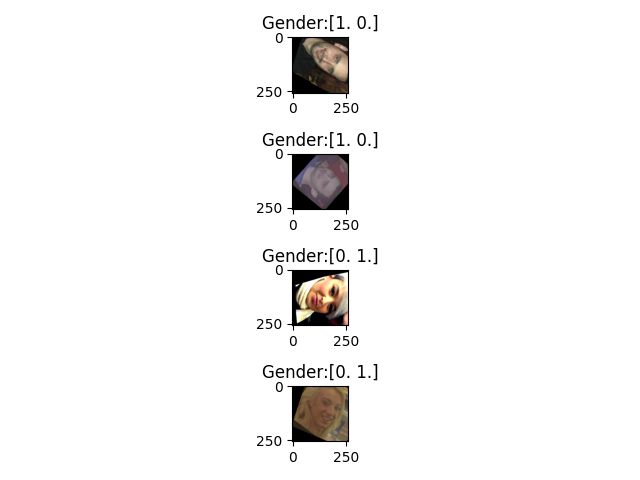

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=(4,4), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 5, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(32, 1, padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(258, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_19')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 128

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 128)          1566496     ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_19"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.98)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-06 03:56:43.540425: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-06 03:56:43.540446: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-06 03:56:43.540466: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-06 03:56:43.658575: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-06 03:56:43.659904: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-06 03:56:44.314476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  13/3528 [..............................] - ETA: 15s - loss: 7135.4663 - gender_out_loss: 0.6881 - tf.math.multiply_1_loss: 5415.1494 - gender_out_accuracy: 0.5577    

2022-11-06 03:56:45.093006: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7733.5308 - gender_out_loss: 0.6973 - tf.math.multiply_1_loss: 5990.3931 - gender_out_accuracy: 0.4771
Epoch 1/300
   1/1000 [..............................] - ETA: 14:20 - loss: 10579.8438 - gender_out_loss: 0.6772 - tf.math.multiply_1_loss: 8886.7646 - gender_out_accuracy: 0.2500

2022-11-06 03:56:59.220447: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-06 03:56:59.220473: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:11 - loss: 9608.9512 - gender_out_loss: 0.7197 - tf.math.multiply_1_loss: 7809.6807 - gender_out_accuracy: 0.3750

2022-11-06 03:56:59.701991: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-06 03:56:59.702835: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-06 03:56:59.732950: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2918 callback api events and 2877 activity events. 
2022-11-06 03:56:59.756839: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-06 03:56:59.783249: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_19/log_0/plugins/profile/2022_11_06_03_56_59

2022-11-06 03:56:59.820580: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_19/log_0/plugins/profile/2022_11_06_03_56_59/rachanon-pc1.trace.json.gz
2022-11-06 03:56:59.858429: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 21s 21ms/step - loss: 4486.1895 - gender_out_loss: 0.6994 - tf.math.multiply_1_loss: 2737.6648 - gender_out_accuracy: 0.5238 - val_loss: 3808.5854 - val_gender_out_loss: 0.6846 - val_tf.math.multiply_1_loss: 2097.1936 - val_gender_out_accuracy: 0.5627
Epoch 2/300
   7/1000 [..............................] - ETA: 8s - loss: 3340.5215 - gender_out_loss: 0.6964 - tf.math.multiply_1_loss: 1599.6395 - gender_out_accuracy: 0.3929

2022-11-06 03:57:19.584023: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251658240 exceeds 10% of free system memory.
2022-11-06 03:57:19.633328: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125829120 exceeds 10% of free system memory.


1000/1000 [==============================] - 20s 20ms/step - loss: 3276.8269 - gender_out_loss: 0.6926 - tf.math.multiply_1_loss: 1545.4272 - gender_out_accuracy: 0.5303 - val_loss: 3240.9104 - val_gender_out_loss: 0.6839 - val_tf.math.multiply_1_loss: 1531.0548 - val_gender_out_accuracy: 0.5504
Epoch 3/300
   8/1000 [..............................] - ETA: 8s - loss: 2695.7935 - gender_out_loss: 0.6762 - tf.math.multiply_1_loss: 1005.2671 - gender_out_accuracy: 0.5000

2022-11-06 03:57:39.326709: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251658240 exceeds 10% of free system memory.
2022-11-06 03:57:39.378030: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125829120 exceeds 10% of free system memory.


1000/1000 [==============================] - 20s 20ms/step - loss: 2921.0017 - gender_out_loss: 0.6631 - tf.math.multiply_1_loss: 1263.3373 - gender_out_accuracy: 0.5882 - val_loss: 3083.4900 - val_gender_out_loss: 0.6871 - val_tf.math.multiply_1_loss: 1365.7218 - val_gender_out_accuracy: 0.5747
Epoch 4/300
   8/1000 [..............................] - ETA: 8s - loss: 2644.5154 - gender_out_loss: 0.7028 - tf.math.multiply_1_loss: 887.5406 - gender_out_accuracy: 0.4062

2022-11-06 03:57:59.143624: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251658240 exceeds 10% of free system memory.


1000/1000 [==============================] - 20s 20ms/step - loss: 2834.0522 - gender_out_loss: 0.6848 - tf.math.multiply_1_loss: 1121.9857 - gender_out_accuracy: 0.5510 - val_loss: 2961.3147 - val_gender_out_loss: 0.6843 - val_tf.math.multiply_1_loss: 1250.5492 - val_gender_out_accuracy: 0.5660
Epoch 5/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2692.2524 - gender_out_loss: 0.6936 - tf.math.multiply_1_loss: 958.2386 - gender_out_accuracy: 0.5042 - val_loss: 2877.2192 - val_gender_out_loss: 0.6851 - val_tf.math.multiply_1_loss: 1164.4019 - val_gender_out_accuracy: 0.5640
Epoch 6/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2615.1375 - gender_out_loss: 0.6575 - tf.math.multiply_1_loss: 971.4290 - gender_out_accuracy: 0.6165 - val_loss: 2970.0127 - val_gender_out_loss: 0.6907 - val_tf.math.multiply_1_loss: 1243.3309 - val_gender_out_accuracy: 0.5331
Epoch 7/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2678.881

Epoch 31/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2342.9521 - gender_out_loss: 0.6555 - tf.math.multiply_1_loss: 704.2812 - gender_out_accuracy: 0.6190 - val_loss: 2483.1055 - val_gender_out_loss: 0.6699 - val_tf.math.multiply_1_loss: 808.4012 - val_gender_out_accuracy: 0.5755
Epoch 32/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2340.0691 - gender_out_loss: 0.6757 - tf.math.multiply_1_loss: 650.7584 - gender_out_accuracy: 0.5753 - val_loss: 2506.6780 - val_gender_out_loss: 0.6709 - val_tf.math.multiply_1_loss: 829.5483 - val_gender_out_accuracy: 0.5764
Epoch 33/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2377.5005 - gender_out_loss: 0.6807 - tf.math.multiply_1_loss: 675.7388 - gender_out_accuracy: 0.5627 - val_loss: 2602.3376 - val_gender_out_loss: 0.6785 - val_tf.math.multiply_1_loss: 906.0598 - val_gender_out_accuracy: 0.5697
Epoch 34/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 58/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2295.3506 - gender_out_loss: 0.6689 - tf.math.multiply_1_loss: 622.9814 - gender_out_accuracy: 0.5890 - val_loss: 2418.5127 - val_gender_out_loss: 0.6666 - val_tf.math.multiply_1_loss: 752.0588 - val_gender_out_accuracy: 0.5778
Epoch 59/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2227.2417 - gender_out_loss: 0.6365 - tf.math.multiply_1_loss: 635.8679 - gender_out_accuracy: 0.6467 - val_loss: 2428.0129 - val_gender_out_loss: 0.6715 - val_tf.math.multiply_1_loss: 749.3807 - val_gender_out_accuracy: 0.5774
Epoch 60/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2293.6331 - gender_out_loss: 0.6691 - tf.math.multiply_1_loss: 620.9184 - gender_out_accuracy: 0.5830 - val_loss: 2397.1313 - val_gender_out_loss: 0.6628 - val_tf.math.multiply_1_loss: 740.0865 - val_gender_out_accuracy: 0.5876
Epoch 61/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 85/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2280.6560 - gender_out_loss: 0.6695 - tf.math.multiply_1_loss: 606.8193 - gender_out_accuracy: 0.5778 - val_loss: 2369.6494 - val_gender_out_loss: 0.6524 - val_tf.math.multiply_1_loss: 738.7531 - val_gender_out_accuracy: 0.6060
Epoch 86/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2303.7998 - gender_out_loss: 0.6768 - tf.math.multiply_1_loss: 611.7864 - gender_out_accuracy: 0.5748 - val_loss: 2414.8582 - val_gender_out_loss: 0.6750 - val_tf.math.multiply_1_loss: 727.2636 - val_gender_out_accuracy: 0.5815
Epoch 87/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2185.0752 - gender_out_loss: 0.6399 - tf.math.multiply_1_loss: 585.2850 - gender_out_accuracy: 0.6285 - val_loss: 2709.3442 - val_gender_out_loss: 0.7795 - val_tf.math.multiply_1_loss: 760.6138 - val_gender_out_accuracy: 0.5569
Epoch 88/300
1000/1000 [==============================] - 20s 20ms/step - lo

1000/1000 [==============================] - 20s 20ms/step - loss: 2181.3689 - gender_out_loss: 0.6349 - tf.math.multiply_1_loss: 594.1695 - gender_out_accuracy: 0.6355 - val_loss: 2351.5984 - val_gender_out_loss: 0.6521 - val_tf.math.multiply_1_loss: 721.4594 - val_gender_out_accuracy: 0.6136
Epoch 138/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2257.0049 - gender_out_loss: 0.6574 - tf.math.multiply_1_loss: 613.6172 - gender_out_accuracy: 0.6130 - val_loss: 2483.7366 - val_gender_out_loss: 0.6701 - val_tf.math.multiply_1_loss: 808.5487 - val_gender_out_accuracy: 0.5948
Epoch 139/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2275.3733 - gender_out_loss: 0.6720 - tf.math.multiply_1_loss: 595.2803 - gender_out_accuracy: 0.5850 - val_loss: 2363.1416 - val_gender_out_loss: 0.6579 - val_tf.math.multiply_1_loss: 718.4609 - val_gender_out_accuracy: 0.5951
Epoch 140/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2153.7

1000/1000 [==============================] - 20s 20ms/step - loss: 2266.9912 - gender_out_loss: 0.6608 - tf.math.multiply_1_loss: 615.0104 - gender_out_accuracy: 0.6227 - val_loss: 2293.9114 - val_gender_out_loss: 0.6430 - val_tf.math.multiply_1_loss: 686.3826 - val_gender_out_accuracy: 0.6219
Epoch 190/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2186.9294 - gender_out_loss: 0.6343 - tf.math.multiply_1_loss: 601.1238 - gender_out_accuracy: 0.6302 - val_loss: 2374.5325 - val_gender_out_loss: 0.6571 - val_tf.math.multiply_1_loss: 731.6769 - val_gender_out_accuracy: 0.6274
Epoch 191/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2239.5789 - gender_out_loss: 0.6575 - tf.math.multiply_1_loss: 595.8297 - gender_out_accuracy: 0.6080 - val_loss: 2426.4668 - val_gender_out_loss: 0.6544 - val_tf.math.multiply_1_loss: 790.4332 - val_gender_out_accuracy: 0.5988
Epoch 192/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2207.0

1000/1000 [==============================] - 20s 20ms/step - loss: 2209.2146 - gender_out_loss: 0.6565 - tf.math.multiply_1_loss: 567.9081 - gender_out_accuracy: 0.6143 - val_loss: 2429.2585 - val_gender_out_loss: 0.6370 - val_tf.math.multiply_1_loss: 836.8817 - val_gender_out_accuracy: 0.6272
Epoch 242/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2236.1567 - gender_out_loss: 0.6623 - tf.math.multiply_1_loss: 580.5202 - gender_out_accuracy: 0.6105 - val_loss: 2284.6851 - val_gender_out_loss: 0.6406 - val_tf.math.multiply_1_loss: 683.2513 - val_gender_out_accuracy: 0.6379
Epoch 243/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2187.6306 - gender_out_loss: 0.6339 - tf.math.multiply_1_loss: 602.8862 - gender_out_accuracy: 0.6317 - val_loss: 2333.2751 - val_gender_out_loss: 0.6530 - val_tf.math.multiply_1_loss: 700.7583 - val_gender_out_accuracy: 0.6296
Epoch 244/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2223.7

1000/1000 [==============================] - 20s 20ms/step - loss: 2204.8110 - gender_out_loss: 0.6554 - tf.math.multiply_1_loss: 566.3807 - gender_out_accuracy: 0.6093 - val_loss: 2297.6069 - val_gender_out_loss: 0.6477 - val_tf.math.multiply_1_loss: 678.3589 - val_gender_out_accuracy: 0.6279
Epoch 294/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2170.9470 - gender_out_loss: 0.6416 - tf.math.multiply_1_loss: 566.8260 - gender_out_accuracy: 0.6308 - val_loss: 2332.1807 - val_gender_out_loss: 0.6331 - val_tf.math.multiply_1_loss: 749.3941 - val_gender_out_accuracy: 0.6292
Epoch 295/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2207.9624 - gender_out_loss: 0.6535 - tf.math.multiply_1_loss: 574.1214 - gender_out_accuracy: 0.6125 - val_loss: 2266.9680 - val_gender_out_loss: 0.6354 - val_tf.math.multiply_1_loss: 678.4119 - val_gender_out_accuracy: 0.6318
Epoch 296/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2153.4

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[5.80988824e-01, 4.48611528e-01, 3.90672237e-01],
          [1.66514665e-01, 8.35575163e-02, 1.32103711e-01],
          [1.87542737e-01, 8.95003974e-02, 1.19381994e-01],
          ...,
          [4.99901175e-02, 4.34164703e-02, 6.53260946e-02],
          [8.04036856e-02, 6.39657676e-02, 1.11159235e-01],
          [1.87603533e-01, 1.50707513e-01, 1.86152011e-01]],
 
         [[3.13300788e-01, 8.88468325e-02, 1.74129456e-01],
          [1.23531371e-01, 3.08163464e-02, 2.55574286e-02],
          [1.45190209e-01, 5.80228865e-02, 3.84767354e-02],
          ...,
          [7.12993741e-02, 3.67212296e-02, 4.81662154e-02],
          [7.49547780e-02, 5.97631931e-02, 9.81715322e-02],
          [9.52760875e-02, 1.08392984e-01, 1.43685490e-01]],
 
         [[1.86668783e-01, 9.47137177e-02, 8.45150650e-02],
          [4.74898517e-02, 4.37584519e-02, 4.18357551e-02],
          [5.48386574e-02, 5.44662774e-02, 4.73454595e-0

<IPython.core.display.Javascript object>


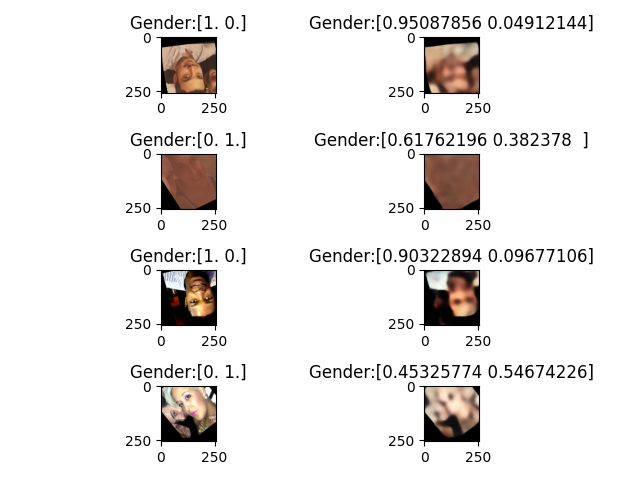

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[4.26815897e-01, 3.10108960e-01, 2.50657350e-01],
          [1.37727410e-01, 5.83192706e-02, 8.16196203e-02],
          [1.47842467e-01, 6.87991083e-02, 8.42718780e-02],
          ...,
          [6.60024583e-02, 4.61523235e-02, 7.55551457e-02],
          [1.44605041e-01, 1.01097375e-01, 1.55054480e-01],
          [3.21462750e-01, 2.21254528e-01, 3.27588022e-01]],
 
         [[2.06344128e-01, 4.20865417e-02, 7.31156766e-02],
          [9.18182731e-02, 1.63239241e-02, 1.03506446e-02],
          [1.09251738e-01, 3.44489515e-02, 1.97817385e-02],
          ...,
          [5.24371862e-02, 3.78535688e-02, 6.18986785e-02],
          [9.23046470e-02, 8.00161064e-02, 1.91638917e-01],
          [1.40805244e-01, 1.72100365e-01, 2.93777436e-01]],
 
         [[9.91822779e-02, 5.59937954e-02, 4.26793098e-02],
          [2.75181234e-02, 2.34827399e-02, 1.73802674e-02],
          [3.39093804e-02, 2.77081132e-02, 1.98121369e-0

<IPython.core.display.Javascript object>


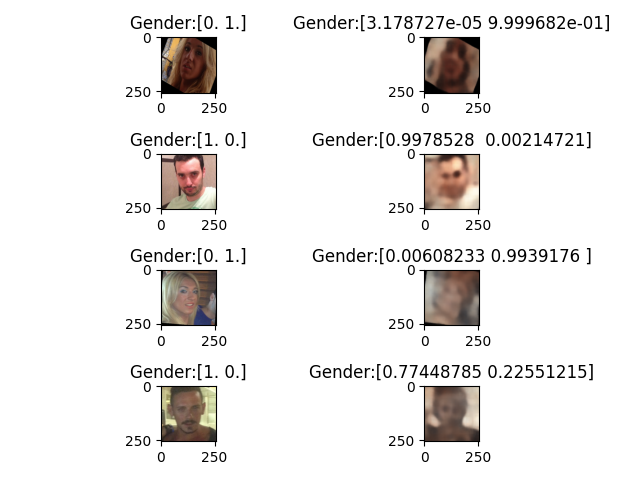

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()